In [1]:
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from astropy.io import fits
import imageio
import numpy as np
import scipy
from scipy import linalg
import imageio.v2 as imageio
from imageio.core import util as imageio_util
import matplotlib.cm as cm
from psf_functions import *
from matplotlib.patches import Rectangle
from scipy import signal

folder_calibration = '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/Calibration_files_papyrus'
folder_data = '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_02-33-47'
folder_ARPOGE_data = '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/ARPOGE/data'

%matplotlib inline

# Data

## PSF

In [2]:
%matplotlib inline
# --- crop window ---
#01.10.25
#y0, y1 = 220, 320
#x0, x1 = 275, 375

#02.10.25
#y0, y1 = 220, 320
#x0, x1 = 285, 385

#30.09.25
#y0, y1 = 220, 320
#x0, x1 = 275, 375

y0, y1 = 200, 340
x0, x1 = 255, 395

log_eps = 1e-3

# --- load + crop cube ---
cube = fits.getdata(os.path.join(folder_data, 'cred2.fits')).astype(float)
#cube = fits.getdata(os.path.join('/Users/muskanshinde/Downloads/RISTRETTO Sept29-Oct3 PSFs/2025-10-02', 'Mirach_3s_closed_loop-OL-2025-10-02T02_51_47-Cube.fits')).astype(float)
print('full cube shape (t, y, x):', cube.shape)
psf_data = cube
psf_data = cube[:, y0:y1, x0:x1]  # cropped cube (t, h, w)
print('cropped cube shape:', psf_data.shape)

full cube shape (t, y, x): (25, 512, 640)
cropped cube shape: (25, 140, 140)


psf size: (140, 140) psf max: 41164.473600000005


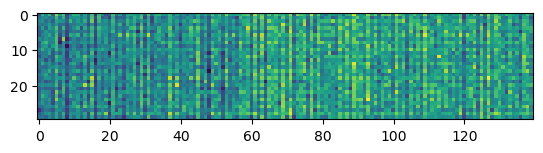

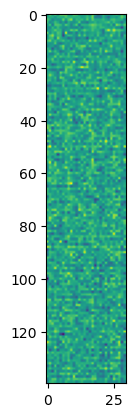

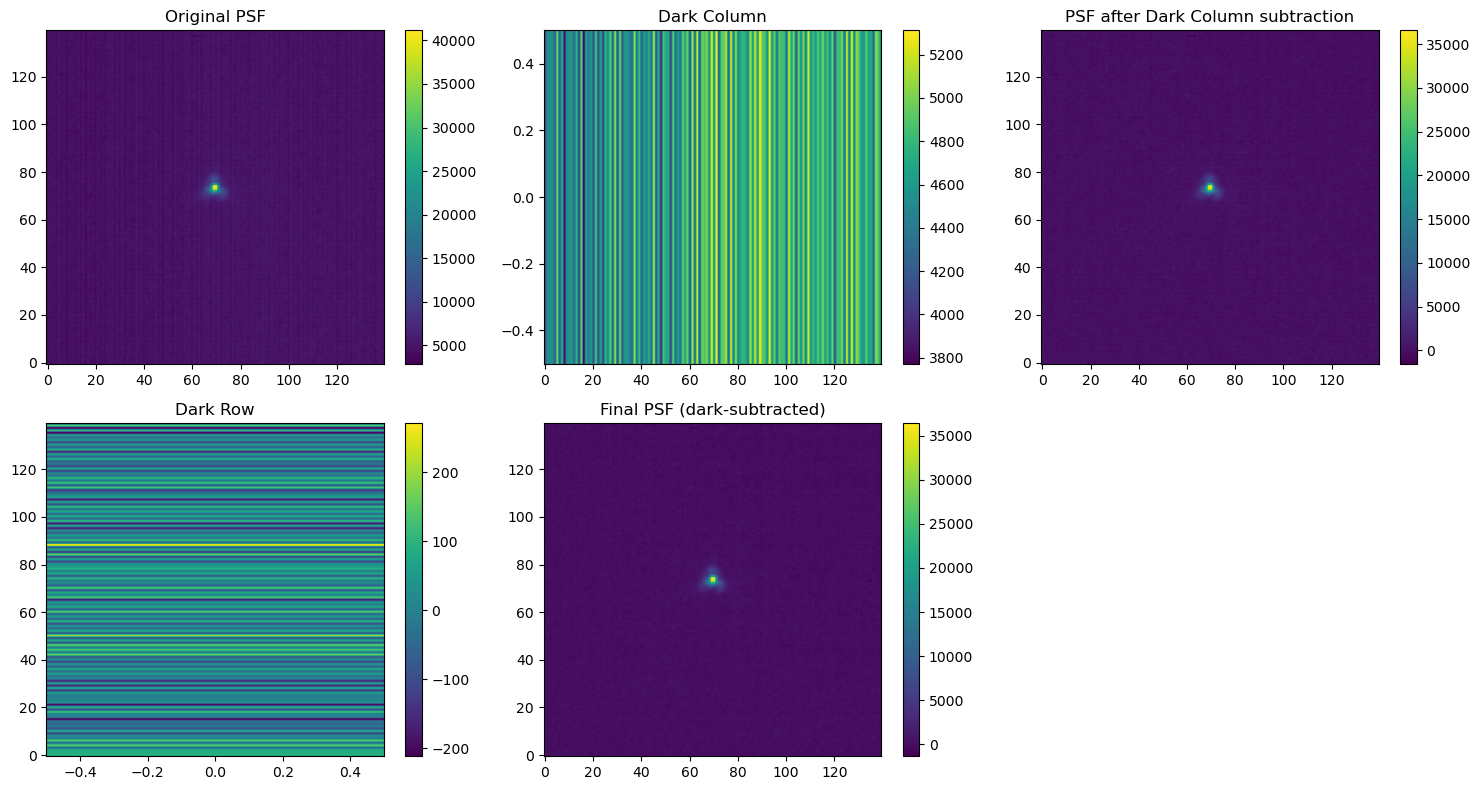

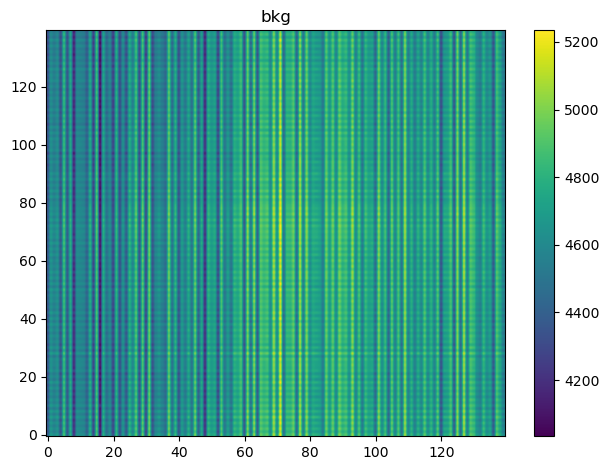

In [3]:
%matplotlib inline
# --- averaged PSF on cropped data ---
psf = np.mean(psf_data, axis=0)  # (h, w)
#psf = np.var(psf_data[:-2,:,:], axis=0)  # (h, w)
print("psf size:", psf.shape, "psf max:", psf.max())

# --- dark estimate from bottom rows ---
dark = psf[0:30, :]
plt.figure()
plt.imshow(dark)
plt.show()
dark_row = np.median(dark, axis=0)[np.newaxis, :]

# subtract dark_row first
psf_after_row_sub = psf - dark_row

# --- dark estimate from rightmost columns on the row-corrected PSF ---
dark = psf_after_row_sub[:, 0:30]
plt.figure()
plt.imshow(dark)
plt.show()
dark_column = np.median(dark, axis=1)[:, np.newaxis]

# subtract dark_column second → FINAL result
psf_dark_sub_final = psf_after_row_sub - dark_column

# --------------------
# Plot all stages
# --------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

# Original PSF
im0 = axes[0].imshow(psf, aspect='auto', origin='lower')
axes[0].set_title('Original PSF')
plt.colorbar(im0, ax=axes[0])

# Dark Row (but this profile runs horizontally → actually a COLUMN background)
im1 = axes[1].imshow(dark_row, aspect='auto', origin='lower')
axes[1].set_title('Dark Column')
plt.colorbar(im1, ax=axes[1])

# After row subtraction
im2 = axes[2].imshow(psf_after_row_sub, aspect='auto', origin='lower')
axes[2].set_title('PSF after Dark Column subtraction')
plt.colorbar(im2, ax=axes[2])

# Dark Column (but this varies vertically → actually a ROW background)
im3 = axes[3].imshow(dark_column, aspect='auto', origin='lower')
axes[3].set_title('Dark Row')
plt.colorbar(im3, ax=axes[3])

# Final PSF
im4 = axes[4].imshow(psf_dark_sub_final, aspect='auto', origin='lower')
axes[4].set_title('Final PSF (dark-subtracted)')
plt.colorbar(im4, ax=axes[4])

axes[5].axis('off')

plt.tight_layout()
plt.show()

#Plot dark Romain's code
bkg = structured_bkg(psf)
plt.figure()
plt.imshow(bkg, aspect='auto', origin='lower')
plt.colorbar()
plt.title(f'bkg')
plt.tight_layout()
plt.show()



132.74232576000014


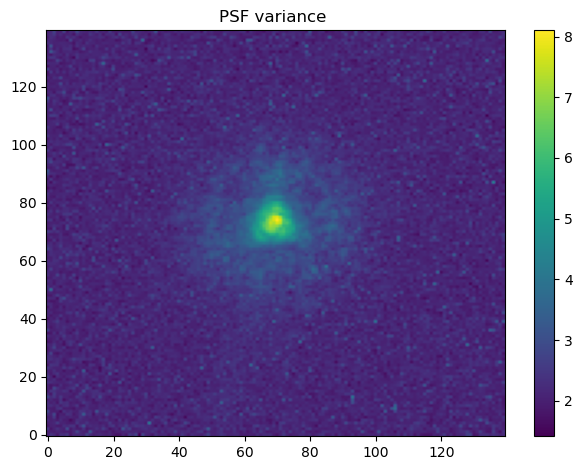

/var/folders/yb/4yjt1n4x6ss7h64bzj7n3pj80000gn/T/ipykernel_36629/3809470010.py:18: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(psf), vmax= 6, vmin=0, aspect='auto', origin='lower')


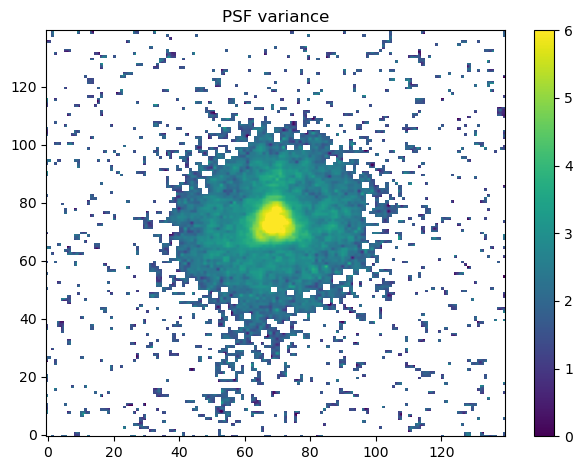

In [4]:
%matplotlib inline
# ---------- plotting ----------
psf_var = np.var(psf_data, axis=0)
median_level = np.median(psf_var[:, 110:])
print(median_level)


plt.figure()
plt.imshow(np.log10(psf_var), aspect='auto', origin='lower')
plt.colorbar()
plt.title(f'PSF variance ')
plt.tight_layout()
plt.show()

psf = psf_var-median_level

plt.figure()
plt.imshow(np.log10(psf), vmax= 6, vmin=0, aspect='auto', origin='lower')
plt.colorbar()
plt.title(f'PSF variance')
plt.tight_layout()
plt.show()



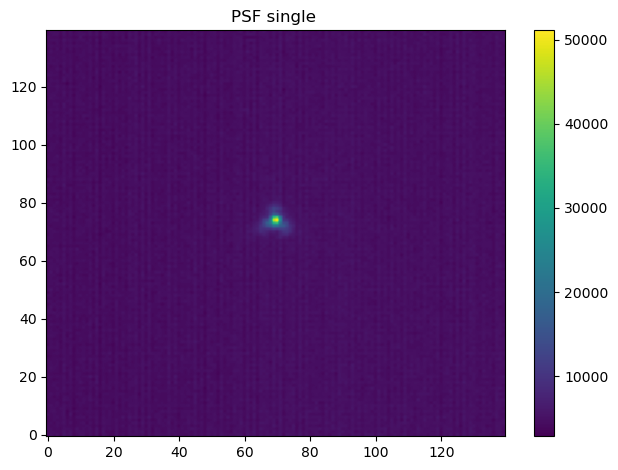

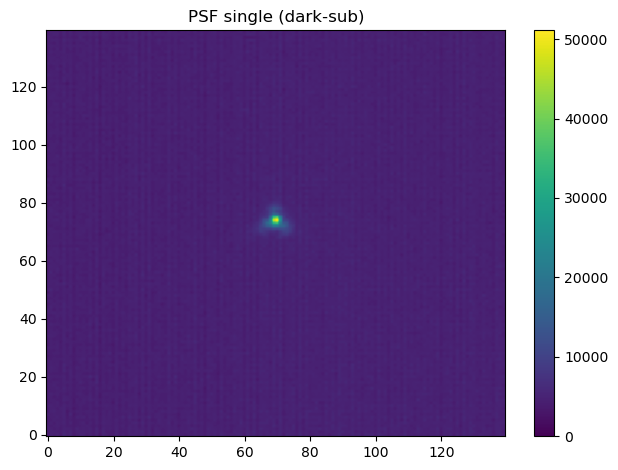

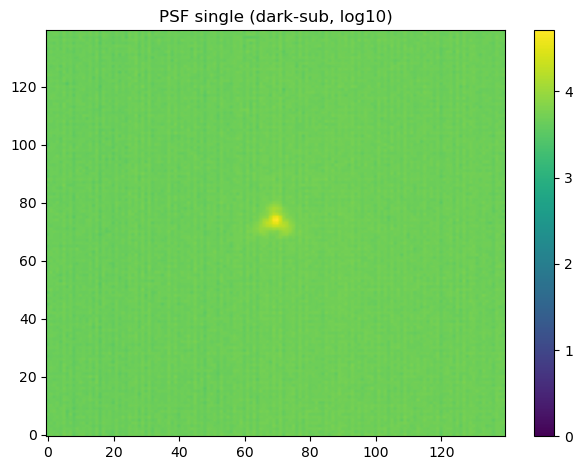

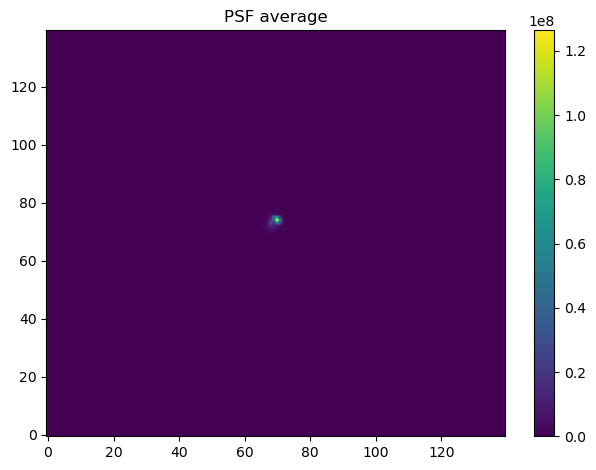

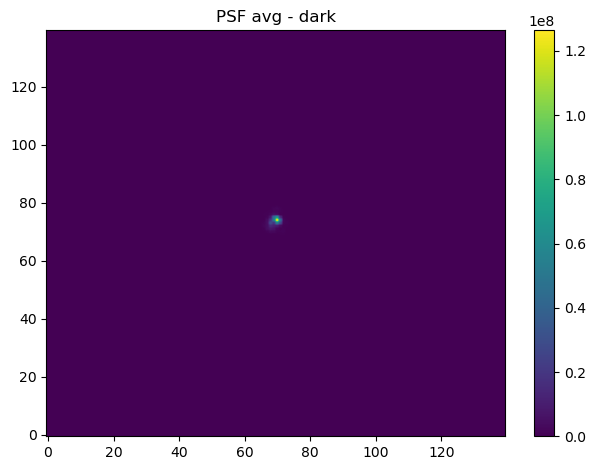

/var/folders/yb/4yjt1n4x6ss7h64bzj7n3pj80000gn/T/ipykernel_36629/2017767920.py:51: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(psf), aspect='auto', origin='lower', vmax= 5, vmin=-1,)


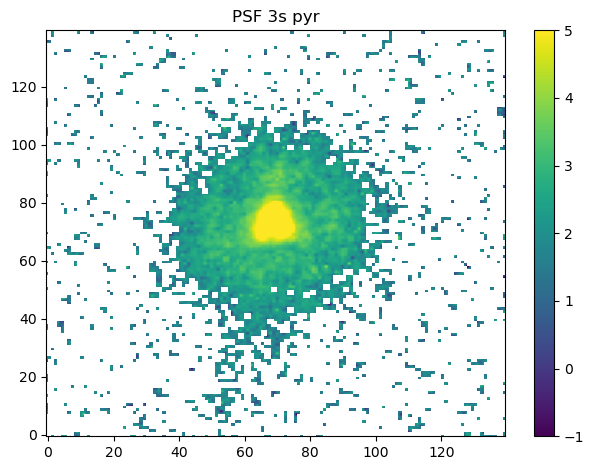

In [5]:
# ---------- plotting ----------
# 1) single, cropped frame
idx = 0 
single = psf_data[idx]

plt.figure()
plt.imshow(single, aspect='auto', origin='lower')
plt.colorbar()
plt.title(f'PSF single ')
plt.tight_layout()
plt.show()

# 2) same single frame, dark-sub 
single = psf_data[idx] #- (dark_row + dark_column)

plt.figure()
plt.imshow((single), aspect='auto', origin='lower', vmin=0)
plt.colorbar()
plt.title(f'PSF single (dark-sub)')
plt.tight_layout()
plt.show()

# 3) same single frame, dark-sub, log 
single = psf_data[idx] #- (dark_row + dark_column)

plt.figure()
plt.imshow(np.log10(single), aspect='auto', origin='lower', vmin=0)
plt.colorbar()
plt.title(f'PSF single (dark-sub, log10)')
plt.tight_layout()
plt.show()

# 4) averaged PSF 
plt.figure()
plt.imshow(psf, aspect='auto', origin='lower')
plt.colorbar()
plt.title('PSF average')
plt.tight_layout()
plt.show()

# 5) avg PSF, dark-sub
plt.figure()
plt.imshow((psf ), aspect='auto', origin='lower')
plt.colorbar()
plt.title('PSF avg - dark')
plt.tight_layout()
plt.show()

# 6) avg PSF, dark-sub, log 
plt.figure()
plt.imshow(np.log10(psf), aspect='auto', origin='lower', vmax= 5, vmin=-1,)
plt.colorbar()
plt.title('PSF 3s pyr')
plt.tight_layout()
plt.savefig(os.path.join(folder_data, f"PSF.png"), dpi=300, transparent=True )
plt.show()

plt.close('all')

crop size: (30, 30)
psf center (peak): 74 70
psf COM (global): 73.75222032512862 69.55067836839144
EE (3x3): 0.6983693327011288


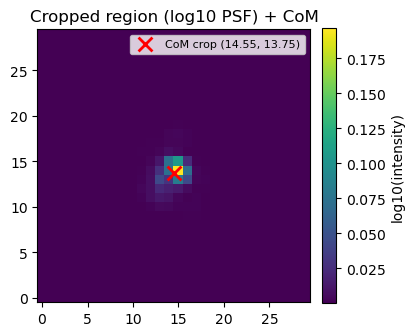

/var/folders/yb/4yjt1n4x6ss7h64bzj7n3pj80000gn/T/ipykernel_36629/731869626.py:54: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(psf_norm), origin='lower', aspect='equal')


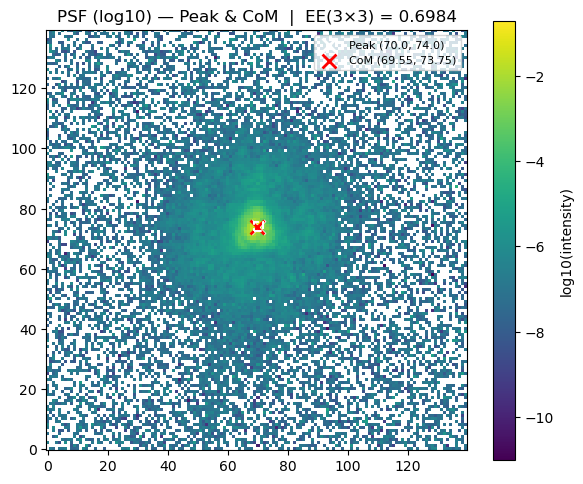

In [6]:
# --- normalize PSF ---
total_flux = psf.sum()
psf_norm = psf / total_flux

# --- log image for peak/CoM (guard small/zero) ---
psf_log = psf #np.log10
# --- peak on full image (log-space, to match your workflow) ---
y_peak, x_peak = np.unravel_index(np.argmax(psf_norm), psf_norm.shape)

# --- CoM on cropped region, then map back to global coords ---

#01.10.25
#y0, y1 = 40, 70 
#x0, x1 = 35, 65

#02.10.25
#y0, y1 = 40, 70
#x0, x1 = 30, 60

#30.09.25
#y0, y1 = 44, 74
#x0, x1 = 35, 65

y0, y1 = 60, 90 
x0, x1 = 55, 85


crop = psf_norm #[y0:y1, x0:x1]
y_com_sub, x_com_sub = center_of_mass(crop)         # in crop coordinates
y_com, x_com = y0 + y_com_sub, x0 + x_com_sub       # back to full-image coordinates
print('crop size:', crop.shape)

print('psf center (peak):', y_peak, x_peak)
print("psf COM (global):", y_com, x_com)

# --- encircled energy in 3x3 around peak ---
ee_core = encircled_energy_in_3x3(psf_norm, x_peak, y_peak)
print('EE (3x3):', ee_core)

# --- quick preview of the crop ---
fig_c, ax_c = plt.subplots(figsize=(4.2, 3.8))
imc = ax_c.imshow(crop, origin='lower', aspect='equal')
plt.colorbar(imc, ax=ax_c, fraction=0.046, pad=0.04, label='log10(intensity)')
ax_c.scatter([x_com_sub], [y_com_sub], marker='x', s=100, color='red',
             linewidths=2, label=f'CoM crop ({x_com_sub:.2f}, {y_com_sub:.2f})')

ax_c.set_title('Cropped region (log10 PSF) + CoM')
ax_c.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

# --- plot: log10 PSF with peak & CoM and 3x3 EE box ---
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(np.log10(psf_norm), origin='lower', aspect='equal')
cbar = plt.colorbar(im, ax=ax,
                    label='log10(norm intensity)' if np.isclose(total_flux, 1.0) else 'log10(intensity)')

# --- markers ---
ax.scatter([x_peak], [y_peak], marker='x', s=100, color='white',
            label=f'Peak ({x_peak:.1f}, {y_peak:.1f})', linewidths=2)
ax.scatter([x_com], [y_com], marker='x', s=100, color='red',
            label=f'CoM ({x_com:.2f}, {y_com:.2f})', linewidths=2)

# --- 3×3 box around the peak ---
rect = Rectangle((x_peak - 1.5, y_peak - 1.5), 3, 3,
                 linewidth=1.5, edgecolor='w', facecolor='none', linestyle='--')
ax.add_patch(rect)

ax.set_title(f'PSF (log10) — Peak & CoM  |  EE(3×3) = {ee_core:.4f}')
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

/var/folders/yb/4yjt1n4x6ss7h64bzj7n3pj80000gn/T/ipykernel_36629/501483340.py:11: RuntimeWarning: invalid value encountered in log10
  im0 = axes[0].imshow(np.log10(psf_sqaured), origin="lower", cmap="inferno", vmax= -1, vmin=-8,)


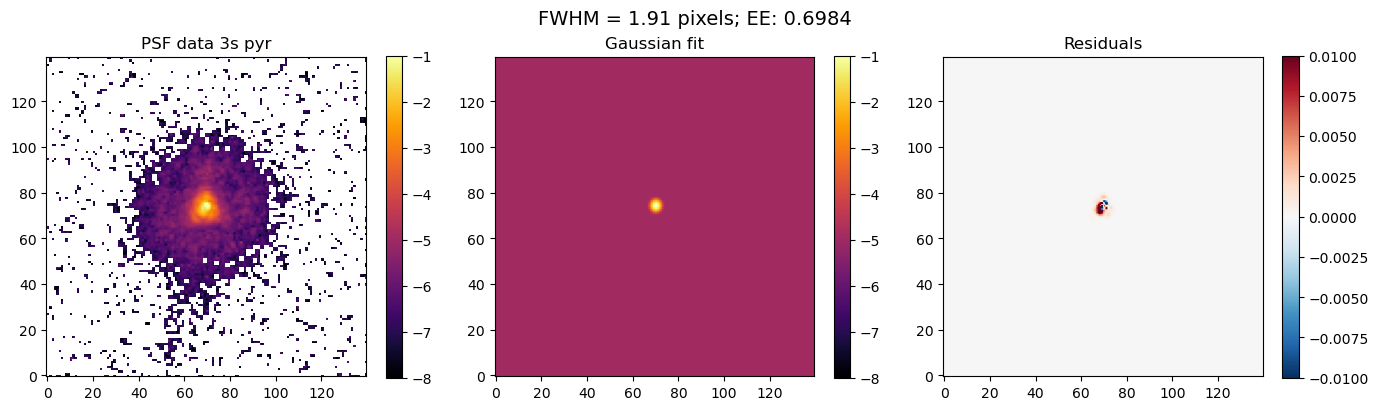

FWHM x: 1.81 pix
FWHM y: 2.00 pix
FWHM geometric mean: 1.91 pix


In [7]:

pixel_scale = 0.07   # arcsec per pixel (example, replace with real value)
psf_sqaured = psf_norm #[y0:y1, x0:x1]
# Fit
(fwhm_x, fwhm_y, fwhm_geom), popt, model = fit_fwhm_2d(psf_sqaured)

# Residuals
residuals = psf_sqaured - model

# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
im0 = axes[0].imshow(np.log10(psf_sqaured), origin="lower", cmap="inferno", vmax= -1, vmin=-8,)
axes[0].set_title("PSF data 3s pyr"); plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(np.log10(model), origin="lower", cmap="inferno", vmax= -1, vmin=-8,)
axes[1].set_title("Gaussian fit"); plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(residuals, origin="lower", cmap="RdBu_r", vmax=0.01, vmin=-0.01)
axes[2].set_title("Residuals"); plt.colorbar(im2, ax=axes[2])

fig.suptitle(
    f"FWHM = {fwhm_geom:.2f} pixels; EE: {ee_core:.4f}",
    fontsize=14
)

plt.tight_layout()
plt.savefig(os.path.join(folder_data, f"FWHM.png"), dpi=300)
plt.show()

print(f"FWHM x: {fwhm_x:.2f} pix")
print(f"FWHM y: {fwhm_y:.2f} pix")
print(f"FWHM geometric mean: {fwhm_geom:.2f} pix")

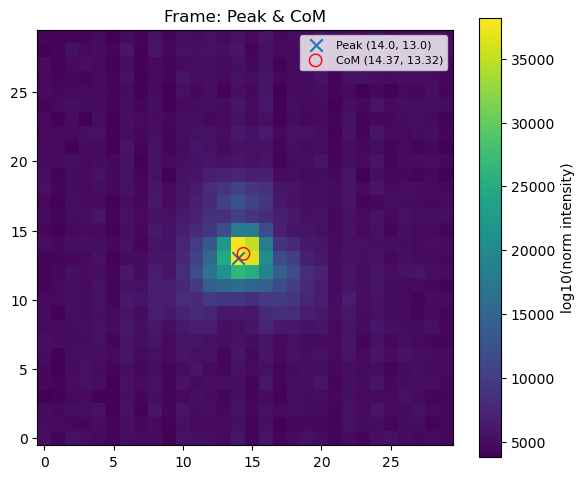

In [8]:
# --- Plot one PSF frame with Peak & CoM ---
i=24
frame = psf_data 
frame = frame[i, y0:y1, x0:x1].astype(float)

# background subtraction
frame = frame #- dark_row

# compute Peak and CoM
y_peak, x_peak = np.unravel_index(np.argmax(frame), frame.shape)
y_com, x_com = center_of_mass((frame**5))

# plot
plt.figure(figsize=(6,5))
plt.imshow((frame), origin='lower', aspect='equal')
plt.colorbar(label='log10(norm intensity)')

plt.scatter([x_peak], [y_peak], marker='x', s=80, label=f'Peak ({x_peak:.1f}, {y_peak:.1f})')
plt.scatter([x_com], [y_com], facecolors='none', edgecolors='r', s=80, label=f'CoM ({x_com:.2f}, {y_com:.2f})')

plt.title('Frame: Peak & CoM')
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


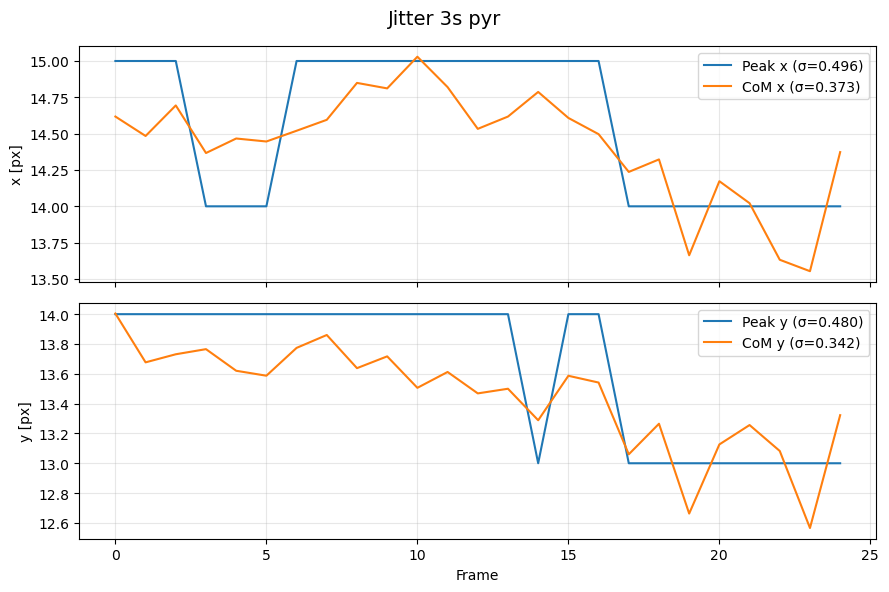

In [9]:
# Load & crop
N = psf_data.shape[0]

peak_x = np.empty(N); peak_y = np.empty(N)
com_x  = np.empty(N); com_y  = np.empty(N)

for i in range(N):
    img = psf_data[i, y0:y1, x0:x1].astype(float)
    
    ypk, xpk = np.unravel_index(np.argmax(img), img.shape)
    ycm, xcm = center_of_mass(img**5)

    peak_x[i], peak_y[i] = xpk, ypk
    com_x[i],  com_y[i]  = xcm, ycm

# Remove NaNs before computing std
px_std = np.nanstd(peak_x)
py_std = np.nanstd(peak_y)
cx_std = np.nanstd(com_x)
cy_std = np.nanstd(com_y)

t = np.arange(N)

fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

fig.suptitle(
    f"Jitter 3s pyr",
    fontsize=14)

axes[0].plot(t, peak_x, label=f'Peak x (σ={px_std:.3f})')
axes[0].plot(t, com_x,  label=f'CoM x (σ={cx_std:.3f})')
axes[0].set_ylabel('x [px]')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
#axes[0].set_ylim(11, 16)

axes[1].plot(t, peak_y, label=f'Peak y (σ={py_std:.3f})')
axes[1].plot(t, com_y,  label=f'CoM y (σ={cy_std:.3f})')
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('y [px]')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
#axes[1].set_ylim(11, 16)

plt.tight_layout()
plt.savefig(os.path.join(folder_data, f"Jitter.png"), dpi=300)
plt.show()


## Frame counters

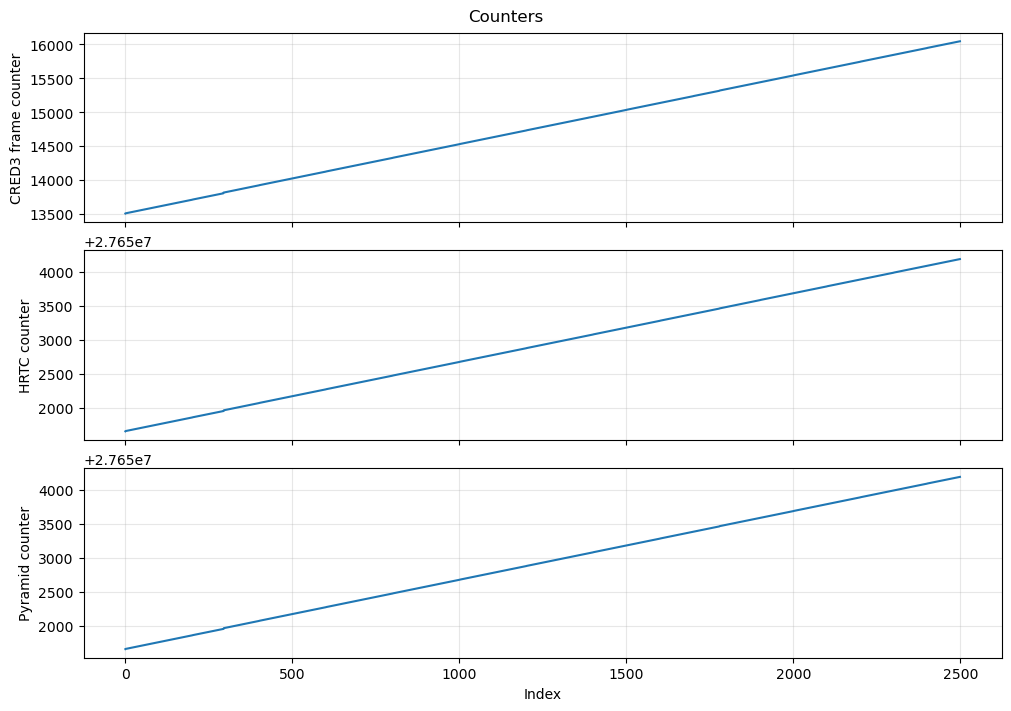

In [10]:
# --- Load data ---
cred3_frame_counter = fits.getdata(os.path.join(folder_data, 'cred3_frame_counter.fits'))
hrtc_counter        = fits.getdata(os.path.join(folder_data, 'hrtc_counter.fits'))
pyramid_counter     = fits.getdata(os.path.join(folder_data, 'pyramid_counter.fits'))


# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True, constrained_layout=True)

axes[0].plot((cred3_frame_counter))
axes[0].set_ylabel("CRED3 frame counter")
axes[0].grid(True, alpha=0.3)
#axes[0].set_ylim(0, 14)

axes[1].plot((hrtc_counter))
axes[1].set_ylabel("HRTC counter")
axes[1].grid(True, alpha=0.3)
#axes[1].set_ylim(0, 14)

axes[2].plot((pyramid_counter))
axes[2].set_ylabel("Pyramid counter")
axes[2].set_xlabel("Index")
axes[2].grid(True, alpha=0.3)
#axes[2].set_ylim(0, 14)

fig.suptitle("Counters")
plt.show()


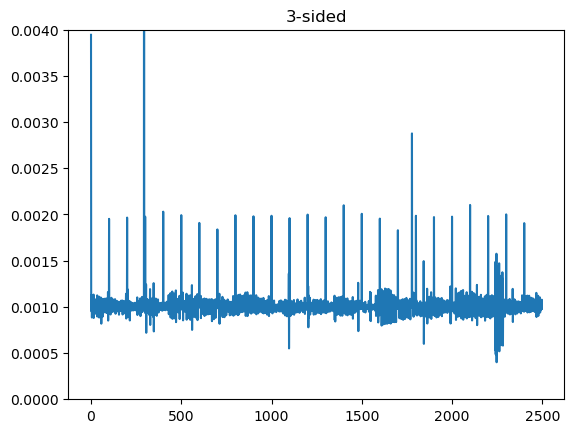

duplicate frames count: 0
missed frames count: 38.900000000000006
0.0010004043579101562


In [11]:
mode_in_timestamps = fits.getdata(os.path.join(folder_data, 'modes_in_ts.fits'))

mode_in_timestamps_diff = np.diff(np.asarray(mode_in_timestamps.squeeze()))
plt.figure()
plt.plot(mode_in_timestamps_diff)
plt.ylim(0, 0.004)
plt.title('3-sided')
plt.show()


# Duplicate frames → positions where diff == 0
duplicate_indices = np.where(mode_in_timestamps_diff == 0)[0]

# Missed frames → positions where diff > 0.0015
missed_indices = np.where(mode_in_timestamps_diff > 0.0015)[0]

print("duplicate frames count:", len(duplicate_indices))
#print("duplicate frames positions:", duplicate_indices)

#print("missed frames time:", np.round(mode_in_timestamps_diff[missed_indices], 4) - 0.001)
print("missed frames count:", np.sum(np.round(mode_in_timestamps_diff[missed_indices], 4) - 0.001) / 0.001)
#print("missed frames positions:", missed_indices)

loop_rate = np.median(mode_in_timestamps_diff)
print(loop_rate)


## Modes, Commands, Voltage

modes_in shape: (2500, 195)
modes_out shape: (2500, 195)
voltages shape: (2500, 241)


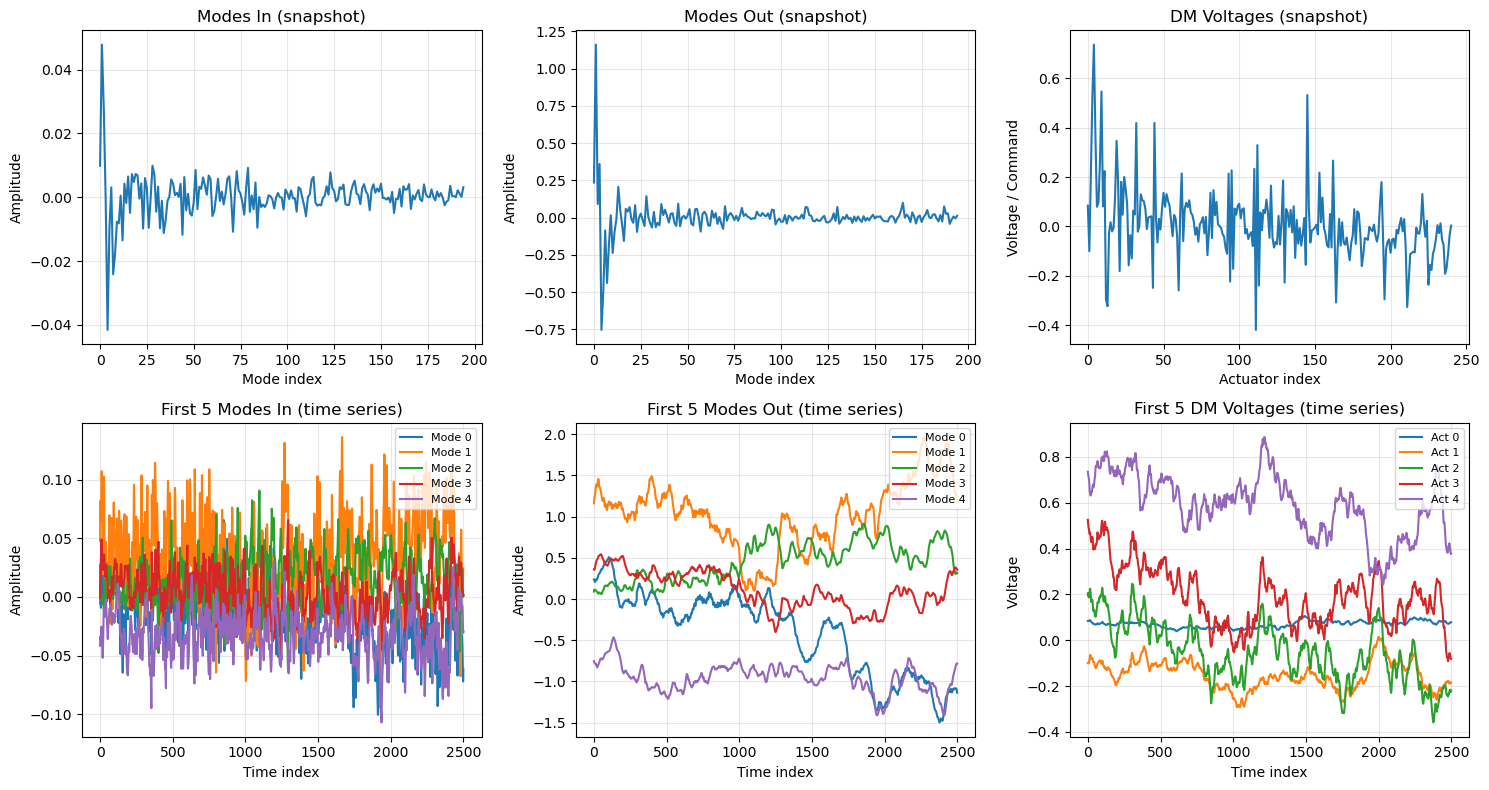

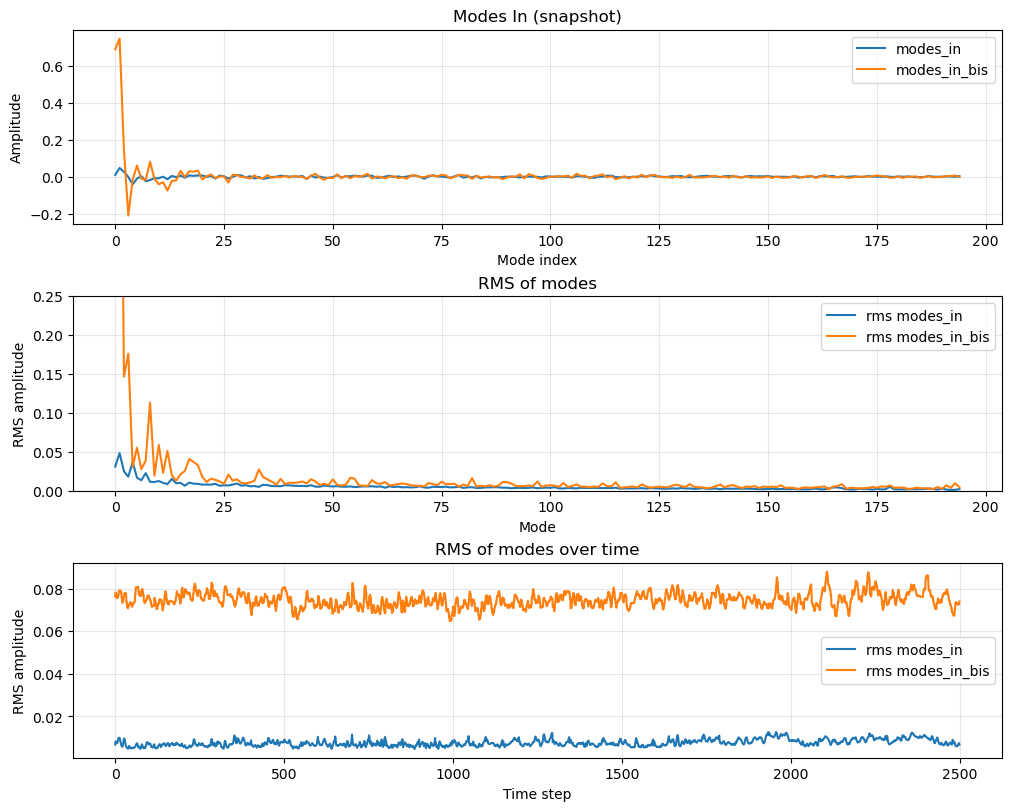

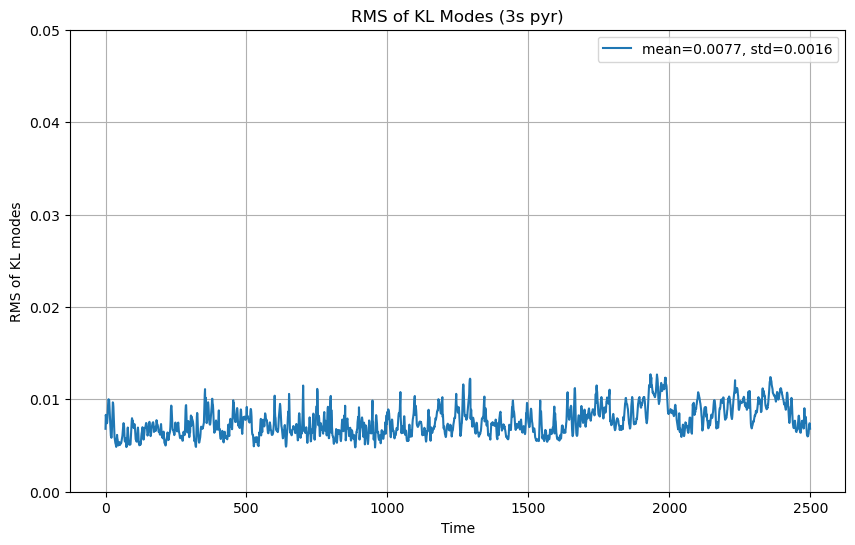

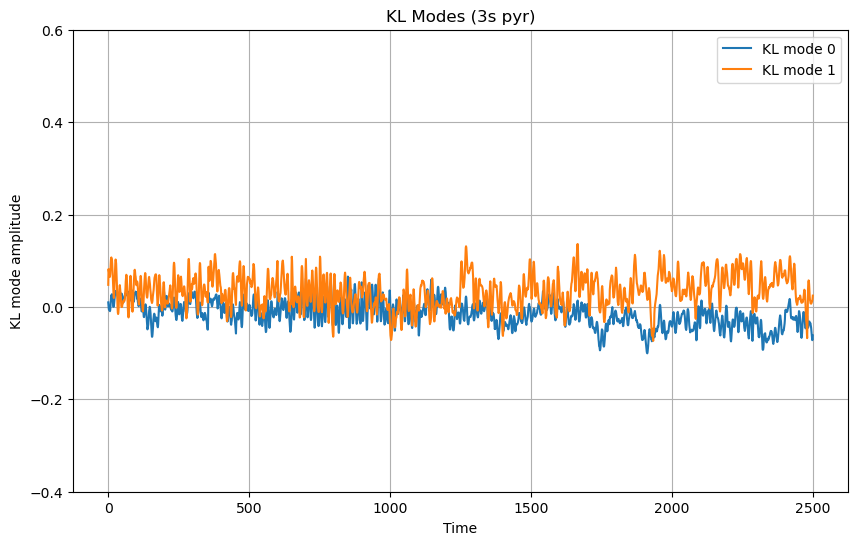

In [12]:

modes_in  = fits.getdata(os.path.join(folder_data, 'modes_in.fits'))
modes_out = fits.getdata(os.path.join(folder_data, 'modes_out.fits'))
voltages  = fits.getdata(os.path.join(folder_data, 'voltages.fits'))
modes_in_bis  = fits.getdata(os.path.join(folder_data, 'modes_in_bis.fits'))

print("modes_in shape:", modes_in.shape)
print("modes_out shape:", modes_out.shape)
print("voltages shape:", voltages.shape)

#tip tilt removed
rms_modes_in = compute_modes_rms(modes_in[:,])
rms_modes_in_bis = compute_modes_rms(modes_in_bis[:,])

rms_modes_in_kl = compute_modes_rms_kl(modes_in)
rms_modes_in_bis_kl = compute_modes_rms_kl(modes_in_bis)

# --- Subplots ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

snapshot_idx = 0  # time index for snapshot

# Snapshot of all modes in
axes[0].plot(modes_in[snapshot_idx, :], label='modes_in')
axes[0].set_title('Modes In (snapshot)')
axes[0].set_xlabel('Mode index')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# Snapshot of all modes out
axes[1].plot(modes_out[snapshot_idx, :])
axes[1].set_title('Modes Out (snapshot)')
axes[1].set_xlabel('Mode index')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

# Snapshot of DM voltages vector
axes[2].plot(voltages[snapshot_idx, :])
axes[2].set_title('DM Voltages (snapshot)')
axes[2].set_xlabel('Actuator index')
axes[2].set_ylabel('Voltage / Command')
axes[2].grid(True, alpha=0.3)

# First up to 5 modes in over time
for i in range(min(5, modes_in.shape[1])):
    axes[3].plot(modes_in[:, i], label=f'Mode {i}')
axes[3].set_title('First 5 Modes In (time series)')
axes[3].set_xlabel('Time index')
axes[3].set_ylabel('Amplitude')
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right', fontsize=8)

# First up to 5 modes out over time
for i in range(min(5, modes_out.shape[1])):
    axes[4].plot(modes_out[:, i], label=f'Mode {i}')
axes[4].set_title('First 5 Modes Out (time series)')
axes[4].set_xlabel('Time index')
axes[4].set_ylabel('Amplitude')
axes[4].grid(True, alpha=0.3)
axes[4].legend(loc='upper right', fontsize=8)

# First up to 5 DM voltages over time
for i in range(min(5, voltages.shape[1])):
    axes[5].plot(voltages[:, i], label=f'Act {i}')
axes[5].set_title('First 5 DM Voltages (time series)')
axes[5].set_xlabel('Time index')
axes[5].set_ylabel('Voltage ')
axes[5].grid(True, alpha=0.3)
axes[5].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

#comparison 3s and 4s pyr modes
fig, axes = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

axes[0].plot(modes_in[snapshot_idx, :], label='modes_in')
axes[0].plot(modes_in_bis[snapshot_idx, :], label='modes_in_bis')
axes[0].set_title('Modes In (snapshot)')
axes[0].set_xlabel('Mode index')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(rms_modes_in_kl, label='rms modes_in')
axes[1].plot(rms_modes_in_bis_kl, label='rms modes_in_bis')
axes[1].set_title('RMS of modes')
axes[1].set_xlabel('Mode')
axes[1].set_ylabel('RMS amplitude')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 0.25)
axes[1].legend()

axes[2].plot(rms_modes_in, label='rms modes_in')
axes[2].plot(rms_modes_in_bis, label='rms modes_in_bis')
axes[2].set_title('RMS of modes over time')
axes[2].set_xlabel('Time step')
axes[2].set_ylabel('RMS amplitude')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.title('RMS of KL Modes (3s pyr)')
plt.xlabel('Time')
plt.ylabel('RMS of KL modes')
mean_val = np.mean(rms_modes_in)
std_val  = np.std(rms_modes_in)
plt.plot(rms_modes_in, label=f"mean={mean_val:.4f}, std={std_val:.4f}")
plt.ylim(0,0.05)
plt.legend()
plt.grid()
plt.savefig(os.path.join(folder_data, "RMS_vs_time.png"), dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.title('KL Modes (3s pyr)')
plt.xlabel('Time')
plt.ylabel('KL mode amplitude')
plt.plot(modes_in[:,0], label=f"KL mode 0")
plt.plot(modes_in[:,1], label=f"KL mode 1")
plt.ylim(-0.4,0.6)
plt.legend()
plt.grid()
plt.savefig(os.path.join(folder_data, "RMS_vs_time_tip_tilt.png"), dpi=300)
plt.show()


## DM channels

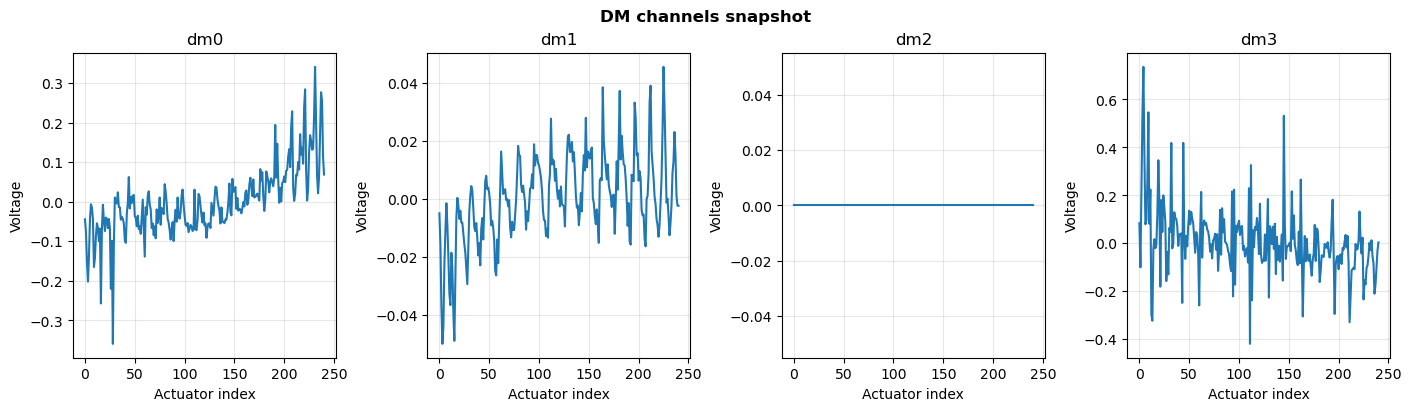

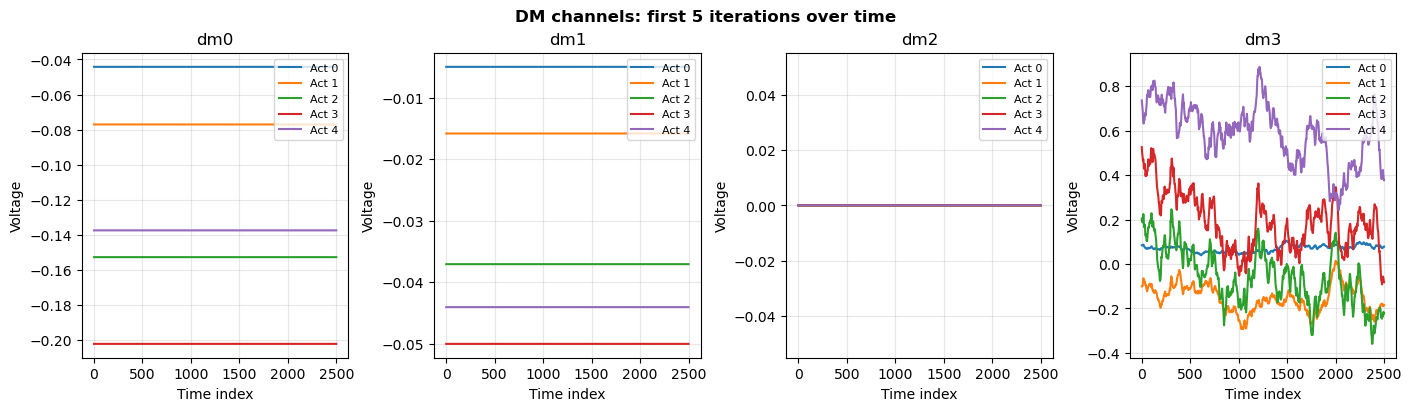

In [13]:
# --- Load 2D DM maps ---
dm0 = fits.getdata(os.path.join(folder_data, 'dm0.fits')).astype(float)
dm1 = fits.getdata(os.path.join(folder_data, 'dm1.fits')).astype(float)
dm2 = fits.getdata(os.path.join(folder_data, 'dm2.fits')).astype(float)
dm3 = fits.getdata(os.path.join(folder_data, 'dm3.fits')).astype(float)

# --- Plot snapshot
fig, axes = plt.subplots(1, 4, figsize=(14, 4), constrained_layout=True)

# Flatten axes so axes[i] is an Axes object
axes = axes.ravel()

# Main title
fig.suptitle("DM channels snapshot", fontsize=12, fontweight="bold")

snapshot_idx = 0  # time index for snapshot

# dm0
axes[0].plot(dm0[snapshot_idx, :])
axes[0].set_title('dm0')
axes[0].set_xlabel('Actuator index')
axes[0].set_ylabel('Voltage')
axes[0].grid(True, alpha=0.3)

# dm1
axes[1].plot(dm1[snapshot_idx, :])
axes[1].set_title('dm1')
axes[1].set_xlabel('Actuator index')
axes[1].set_ylabel('Voltage')
axes[1].grid(True, alpha=0.3)

# dm2
axes[2].plot(dm2[snapshot_idx, :])
axes[2].set_title('dm2')
axes[2].set_xlabel('Actuator index')
axes[2].set_ylabel('Voltage')
axes[2].grid(True, alpha=0.3)

# dm3
axes[3].plot(dm3[snapshot_idx, :])
axes[3].set_title('dm3')
axes[3].set_xlabel('Actuator index')
axes[3].set_ylabel('Voltage')
axes[3].grid(True, alpha=0.3)


# --- Plot over time
fig, axes = plt.subplots(1, 4, figsize=(14, 4), constrained_layout=True)

# Flatten axes so axes[i] is an Axes object
axes = axes.ravel()

# Main title
fig.suptitle("DM channels: first 5 iterations over time", fontsize=12, fontweight="bold")

# Flatten axes for easier 1D indexing
axes = axes.ravel()

# --- dm0 ---
n = 5
for i in range(n):
    axes[0].plot(dm0[:, i], label=f'Act {i}')
axes[0].set_title('dm0')
axes[0].set_xlabel('Time index')
axes[0].set_ylabel('Voltage')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right', fontsize=8)

# --- dm1 ---
for i in range(n):
    axes[1].plot(dm1[:, i], label=f'Act {i}')
axes[1].set_title('dm1')
axes[1].set_xlabel('Time index')
axes[1].set_ylabel('Voltage')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right', fontsize=8)

# --- dm2 ---
for i in range(n):
    axes[2].plot(dm2[:, i], label=f'Act {i}')
axes[2].set_title('dm2')
axes[2].set_xlabel('Time index')
axes[2].set_ylabel('Voltage')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right', fontsize=8)

for i in range(n):
    axes[3].plot(dm3[:, i], label=f'Act {i}')
axes[3].set_title('dm3')
axes[3].set_xlabel('Time index')
axes[3].set_ylabel('Voltage')
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right', fontsize=8)

plt.show()


#PSD

/var/folders/yb/4yjt1n4x6ss7h64bzj7n3pj80000gn/T/ipykernel_36629/1217718425.py:11: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, fs/2)


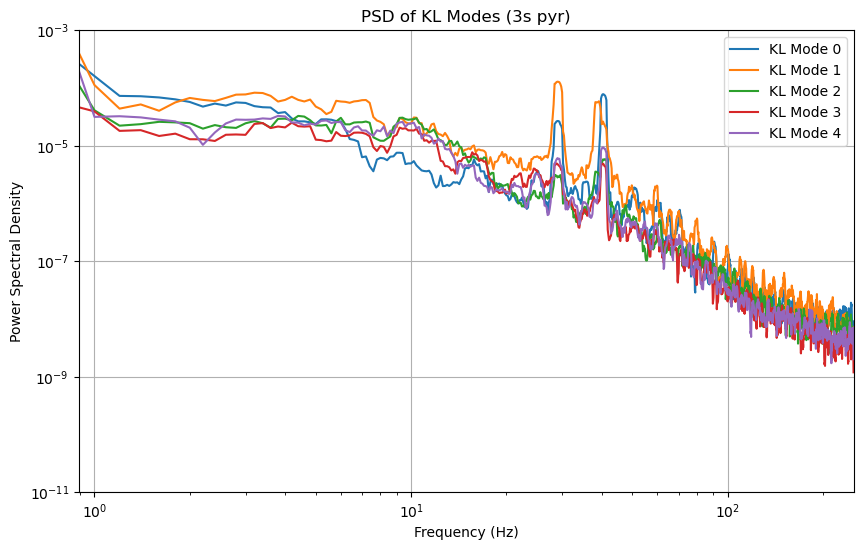

In [14]:
fs = 500  # Sampling frequency
t = np.arange(0, 2500/fs, 1/fs)

plt.figure(figsize=(10, 6))
plt.title('PSD of KL Modes (3s pyr)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-3)
plt.xlim(0, fs/2)

for i in np.arange(0, 5):
    data = modes_in[:, i]

    # Compute PSD (FFT method)
    freqs, psd = compute_psd(data, fs)

    # Smooth PSD
    psd_smooth = smooth_boxcar(psd, N=9)

    plt.plot(freqs, psd_smooth, label=f'KL Mode {i}')

plt.legend()
plt.grid()
plt.savefig(os.path.join(folder_data, "PSD_5modes.png"), dpi=300)
plt.show()


/var/folders/yb/4yjt1n4x6ss7h64bzj7n3pj80000gn/T/ipykernel_36629/3232031830.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, fs/2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


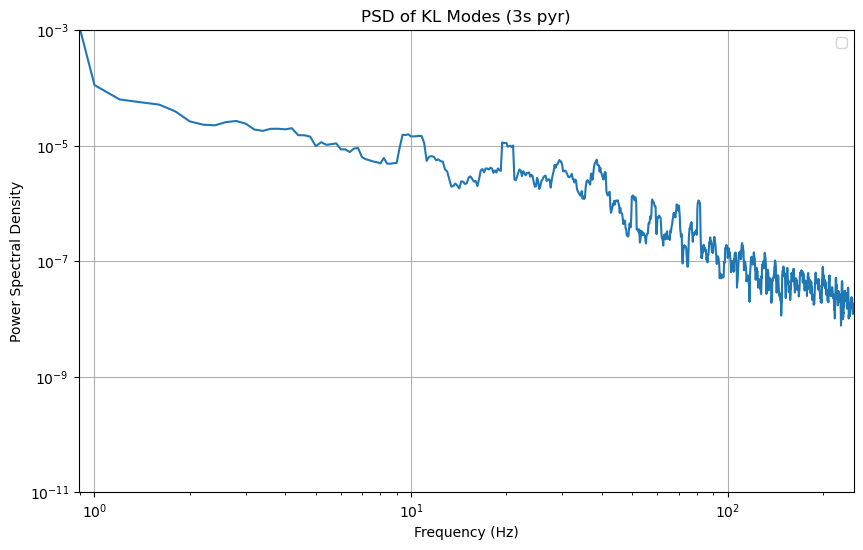

In [15]:
summed_modes = np.sqrt(np.sum(modes_in**2, axis=1)) 

plt.figure(figsize=(10, 6))
plt.title('PSD of KL Modes (3s pyr)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11, 1e-3)
plt.xlim(0, fs/2)

# PSD
freqs, psd = compute_psd(summed_modes, fs)
psd_smooth = smooth_boxcar(psd, N=9)
plt.plot(freqs, psd_smooth)

plt.legend()
plt.grid()
plt.savefig(os.path.join(folder_data, f"PSD.png"), dpi=300)
plt.show()